# Metric comparison

The aim of this notebook is to show the properties of the different metrics that have been implemented to estimate the similarity between two chords. 

Each chord is defined by a root (int), a chord type (ChordType object) and an inversion (int).

In [1]:
import math
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from glob import glob
from fractions import Fraction
from scipy import stats

import sys
sys.path.append('/home/xavier/Documents/dcml/python_scripts')

from metric import get_distance
from data_types import ChordType, PitchType
from constants import TRIAD_REDUCTION

In [2]:
dist_to_Cmaj = pd.read_csv('../Data/dist_to_Cmaj.csv')

TRIAD = set(TRIAD_REDUCTION[chord_type] for chord_type in ChordType)
dist_to_Cmaj['chord_type'] = dist_to_Cmaj['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
dist_to_Cmaj.drop(dist_to_Cmaj.query('chord_type in @TRIAD and inversion == 3').index, inplace=True)

dist_to_Cmaj['chord_type_inv'] = dist_to_Cmaj.apply(lambda r : str(r.chord_type).split(".")[1]+"_inv"+str(r.inversion), axis=1)

In [4]:
sps_programs_toC = pd.read_csv('../Data/sps_programs_toC.csv')

In [5]:
sps_transform_toC = pd.read_csv('../Data/sps_transform_toC.csv')

In [6]:
vl_weighted_toC = pd.read_csv('../Data/vl_weighted_toC.csv')

In [7]:
tbt_weighted_toC = pd.read_csv('../Data/tbt_weighted_toC.csv')

In [8]:
corpus_df = pd.read_csv('../Data/corpus.csv')
corpus_df['sps_accuracy'] = corpus_df['average_sps'].apply(lambda sps :1-sps)
corpus_df['vl_accuracy'] = corpus_df['average_vl'].apply(lambda vl :1-vl)
corpus_df['tbt_accuracy'] = corpus_df['average_tbt'].apply(lambda tbt :1-tbt)

In [41]:
programs_corpus_df = pd.read_csv('../Data/programs_corpus_df.csv')
programs_corpus_df['sps_accuracy'] = programs_corpus_df['average_sps'].apply(lambda sps :1-sps)

___

## Tone by tone metric

This metric is the simpliest one. It computes the number of pitches that belong to both chords. The similarity measure is the number of matches over the maximum possible number of matches between the two chords. 

The match between roots and basses can be weighted by a input parameter. 

The distance is 1-similarity

### Visualization of the output differences when changing the metric parameters : bass and root weight

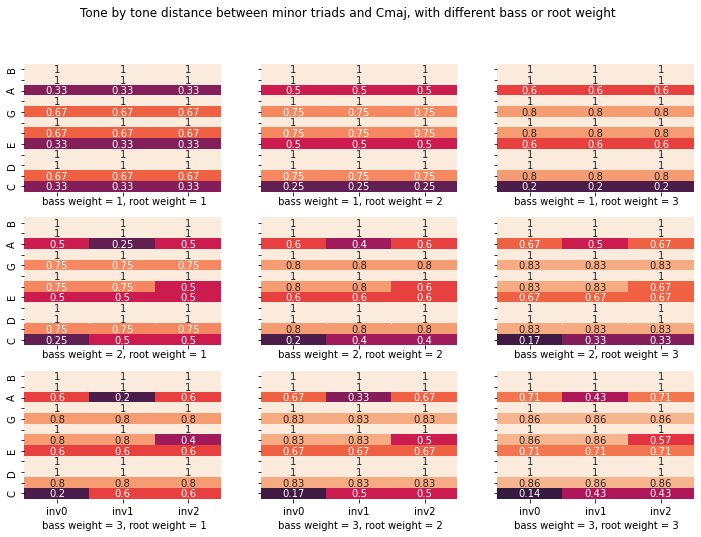

In [10]:
# Visualization of the output differences when changing the metric parameters :
# bass and root weight

fig, ax = plt.subplots(3,3,figsize= (12,8), sharex = True, sharey = True)

for i in range(9):
    sbplt = ax[i%3, math.floor(i/3)]
    
    to_plot = tbt_weighted_toC.pivot(index='root', 
                                     columns='inversion', 
                                     values=f'bass w{i%3+1}, root w{math.floor(i/3)+1}').sort_values('root', ascending=False)
    
    yticklabels = ['B','','A','','G','','','E','','D','','C']
    
    xticklabels = ['inv0', 'inv1', 'inv2']
        
    sns.heatmap(to_plot, annot=True, vmin = 0, vmax = 1,
                xticklabels=xticklabels, yticklabels=yticklabels,
                ax = sbplt, cbar=False)
    sbplt.set(xlabel=f' bass weight = {i%3+1}, root weight = {math.floor(i/3)+1}', ylabel='')

fig.suptitle('Tone by tone distance between minor triads and Cmaj, with different bass or root weight');

___

## Voice leading metric

The voice leading metric computes the number of semitones there are between each pair of pitches in the two chords. The two basses are compare with each other and a matching is done on the two sets of remaining pitches in order to find the best pairs of pitches of the two chords that lower the overall number of semitones.

The matching is done in a way that ensures that each pitche in a chord coresponds to at list one pitche in the other chord : if the two chords have the same size, each pitches is matched once. 

If the number of pitches in the tow chords is different, the function compares the sets of notes (without the basses), finds the best matching, removes the matched pitches in the longest chord and compares the new set of the remaining notes against the full small chord (with its bass). After each matching, the matched pitches are removed until the set is empty, so that each 'extra' pitche of the longest chords can be matched with any pitche in the small chord.

The match between basses can be weighted by a input parameter. 

The function rturns the number of semitones between the two chords.

### Visualization of the output differences when changing the metric parameters : bass weight

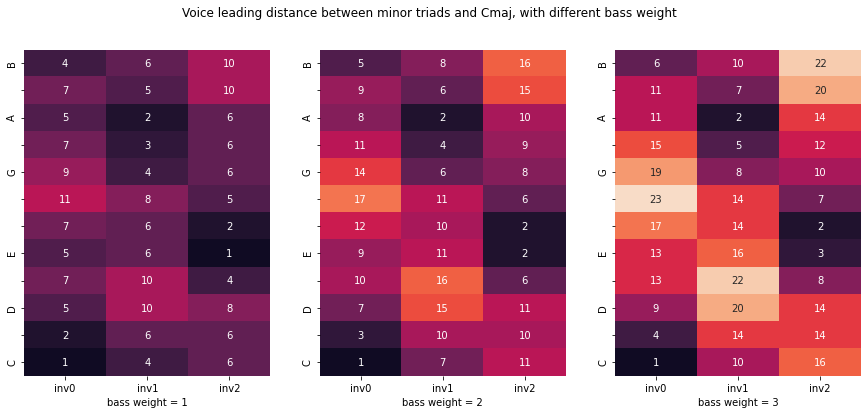

In [11]:
# Visualization of the output differences when changing the metric parameters :
# bass weight

fig, axs = plt.subplots(1,3,figsize = (15,6))

for i in range (3):
    to_plot = vl_weighted_toC.pivot(index='root', 
                        columns='inversion', 
                        values=f'w{i+1}').sort_values('root', ascending=False)
    
    xticklabels = ['inv0', 'inv1', 'inv2']
    
    yticklabels = ['B','','A','','G','','','E','','D','','C']
    
    sns.heatmap(to_plot, annot=True, vmin = 0, vmax = 24,
                xticklabels=xticklabels, yticklabels=yticklabels,
                ax = axs[i],cbar=False)
    axs[i].set(xlabel=f'bass weight = {i+1}', ylabel='')

fig.suptitle('Voice leading distance between minor triads and Cmaj, with different bass weight');

___

## Spectral Pitche Simalirity (SPS) metric

This metric returns the cosin distance between the two spectrum of each chord. 

The chords (their list of notes) are transposed into midi objects (pretty_midi object) so that they can be syntezised (using FluidSynth and a midi program) and their spectrum computed using either stft, cqt, vqt or melspectrogram transformation.

The spectrums can be filtered : For each component of the spectrum, the median magnitude is calculated across a centred window (the fourier transform is zero-padded). If the magnitude of that component is less that a noise-factor times the window’s median, it is considered noise and removed.

Each peaks in the spectrums can also be isolated : If consecutive bins in the spectrum are non-zero, the function keep only the maximum of the bins and filter out the others.

### Visualization of the output differences when changing the metric parameters : spectrum transformation

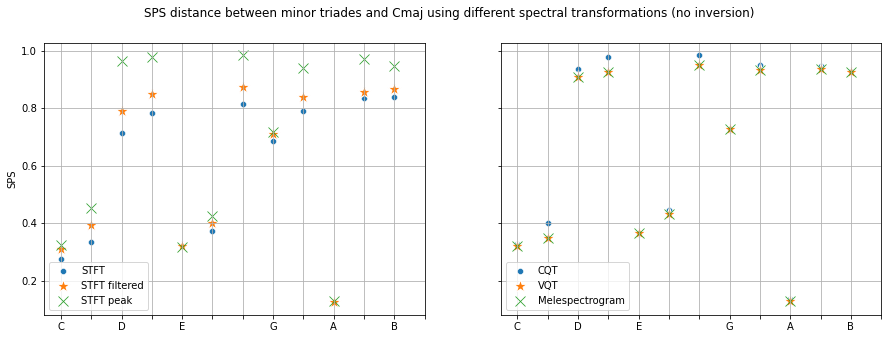

In [12]:
# Visualization of the output differences when changing the metric parameters : spectrum transformation

fig, axs = plt.subplots(1,2, figsize=(15,5), sharey = True)

# STFT parameters comparison
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='stft', label='STFT', marker='o', ax=axs[0]);
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='stft filtered', label='STFT filtered', marker='*', s=200, ax=axs[0])
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='stft peak', label='STFT peak', marker='x', s=100, ax=axs[0])

axs[0].set(xlabel='', ylabel='SPS')
axs[0].set_xticks(np.arange(0,13))
axs[0].set_xticklabels(['C','','D','','E','','','G','','A','','B',''])
axs[0].grid()


# transfom comparison
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='cqt', label='CQT', marker='o', ax=axs[1])
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='vqt', label='VQT', marker='*', s=200, ax=axs[1])
sns.scatterplot(data=sps_transform_toC, 
                     x='root', y='vqt', label='Melespectrogram', marker='x', s=100, ax=axs[1])

axs[1].set(xlabel='', ylabel='SPS')
axs[1].set_xticks(np.arange(0,13))
axs[1].set_xticklabels(['C','','D','','E','','','G','','A','','B', ''])
axs[1].grid()

fig.suptitle('SPS distance between minor triades and Cmaj using different spectral transformations (no inversion)');

___

### Visualization of the output differences when changing the metric parameters : Midi program


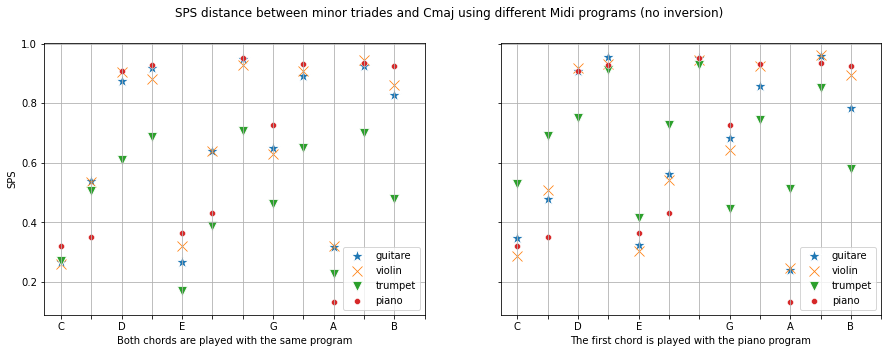

In [13]:
# Visualization of the output differences when changing the metric parameters : Midi program

fig, axs = plt.subplots(1,2, figsize=(15,5), sharey = True)

# Both chords played with same program
sns.scatterplot(data=sps_programs_toC.query('program == 24'), 
                     x='root', y='Guitare', label='guitare', marker='*', s=200, ax=axs[0])
sns.scatterplot(data=sps_programs_toC.query('program == 40'), 
                     x='root', y='Violin', label='violin', marker='x', s=100, ax=axs[0])
sns.scatterplot(data=sps_programs_toC.query('program == 56'), 
                     x='root', y='Trumpet', label='trumpet', marker='v', s=100, ax=axs[0])
sns.scatterplot(data=sps_programs_toC.query('program == 0'), 
                     x='root', y='Piano', label='piano', marker='o', ax=axs[0]);

axs[0].set(xlabel='Both chords are played with the same program', ylabel='SPS')
axs[0].set_xticks(np.arange(0,13))
axs[0].set_xticklabels(['C','','D','','E','','','G','','A','','B', ''])
axs[0].grid()


# First chord played with piano program agains other programs
sns.scatterplot(data=sps_programs_toC.query('program == 0'), 
                     x='root', y='Guitare', label='guitare', marker='*', s=200, ax=axs[1])
sns.scatterplot(data=sps_programs_toC.query('program == 0'), 
                     x='root', y='Violin', label='violin', marker='x', s=100, ax=axs[1])
sns.scatterplot(data=sps_programs_toC.query('program == 0'), 
                     x='root', y='Trumpet', label='trumpet', marker='v', s=100, ax=axs[1])
sns.scatterplot(data=sps_programs_toC.query('program == 0'), 
                     x='root', y='Piano', label='piano', marker='o', ax=axs[1]);

axs[1].set(xlabel='The first chord is played with the piano program', ylabel='SPS')
axs[1].set_xticks(np.arange(0,13))
axs[1].set_xticklabels(['C','','D','','E','','','G','','A','','B', ''])
axs[1].grid()

fig.suptitle('SPS distance between minor triades and Cmaj using different Midi programs (no inversion)');

___
___

# Evaluation of the metrics

Resluts of the different metrics are here compared.

### Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric


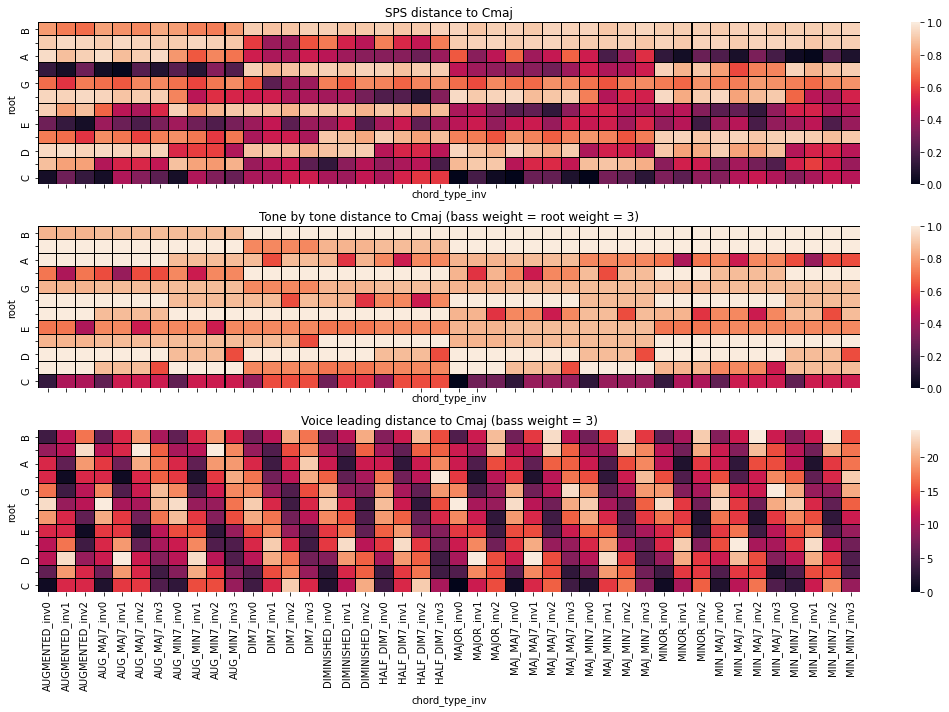

In [14]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric
fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)

to_plot_SPS = dist_to_Cmaj.pivot(index='midi_root', 
                                 columns='chord_type_inv', 
                                 values='SPS_dist').sort_values('midi_root', ascending=False)

    
to_plot_vl = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='voice_leading_dist').sort_values('midi_root', ascending=False)


to_plot_tbt = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='tone_by_tone_dist').sort_values('midi_root', ascending=False)

yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_SPS, yticklabels=yticklabels,
            vmin=0, vmax=1, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'SPS distance to Cmaj', ylabel='root')    

sns.heatmap(to_plot_tbt, yticklabels=yticklabels,
            vmin=0, vmax=1, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Tone by tone distance to Cmaj (bass weight = root weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()

___

In [15]:
# Sorted data frame for each metric 

closest_chords_SPS = dist_to_Cmaj.sort_values('SPS_dist')[['midi_root','chord_type_inv',
                                                           'SPS_dist','chord_type','inversion']]

closest_chords_vl = dist_to_Cmaj.sort_values('voice_leading_dist')[['midi_root','chord_type_inv',
                                                                    'voice_leading_dist','chord_type',
                                                                    'inversion']]

closest_chords_tbt = dist_to_Cmaj.sort_values('tone_by_tone_dist')[['midi_root','chord_type_inv',
                                                                     'tone_by_tone_dist','chord_type',
                                                                     'inversion']]


In [16]:
# Normalization of voice leading metric data frame

closest_chords_vl_normalized = closest_chords_vl.copy()
closest_chords_vl_normalized['voice_leading_dist'] = closest_chords_vl_normalized['voice_leading_dist'].apply(lambda r :
                                                                                        r/max(closest_chords_vl_normalized['voice_leading_dist']))

# Data frame of all the distances sorted wrt to voice leading metric 

sorted_by_vl = pd.concat([closest_chords_vl_normalized, pd.concat([closest_chords_SPS,closest_chords_tbt],
                                                    ignore_index=True)],
                      ignore_index=True)

sorted_by_vl['dist'] = pd.concat([closest_chords_vl_normalized['voice_leading_dist'],
                               pd.concat([closest_chords_SPS['SPS_dist'],
                                          closest_chords_tbt['tone_by_tone_dist']], 
                                         ignore_index=True)],
                      ignore_index=True)

sorted_by_vl['metric'] = pd.Series(['voice leading']*528 +['SPS']*528+['tone by tone']*528 )
sorted_by_vl.drop(labels=['voice_leading_dist','SPS_dist','tone_by_tone_dist'], axis=1, inplace=True)

# Data frame of all the distances sorted wrt to SPS metric 

sorted_by_sps = pd.concat([closest_chords_SPS, pd.concat([closest_chords_vl_normalized,closest_chords_tbt],
                                                    ignore_index=True)],
                      ignore_index=True)

sorted_by_sps['dist'] = pd.concat([closest_chords_SPS['SPS_dist'],
                               pd.concat([closest_chords_vl_normalized['voice_leading_dist'],
                                          closest_chords_tbt['tone_by_tone_dist']], 
                                         ignore_index=True)],
                      ignore_index=True)

sorted_by_sps['metric'] = pd.Series(['SPS']*528 +['voice leading']*528+['tone by tone']*528 )
sorted_by_sps.drop(labels=['voice_leading_dist','SPS_dist','tone_by_tone_dist'], axis=1, inplace=True)

# Data frame of all the distances sorted wrt to tone by tone metric 

sorted_by_tbt = pd.concat([closest_chords_tbt, pd.concat([closest_chords_vl_normalized,closest_chords_SPS],
                                                    ignore_index=True)],
                      ignore_index=True)

sorted_by_tbt['dist'] = pd.concat([closest_chords_tbt['tone_by_tone_dist'],
                               pd.concat([closest_chords_vl_normalized['voice_leading_dist'],
                                          closest_chords_SPS['SPS_dist']], 
                                         ignore_index=True)],
                      ignore_index=True)

sorted_by_tbt['metric'] = pd.Series(['tone by tone']*528 +['voice leading']*528+['SPS']*528 )
sorted_by_tbt.drop(labels=['voice_leading_dist','SPS_dist','tone_by_tone_dist'], axis=1, inplace=True)

### Visualization of the results of the different metrics : every C chord with is compared against C major triad for each metric (sorted each time by a different metric)


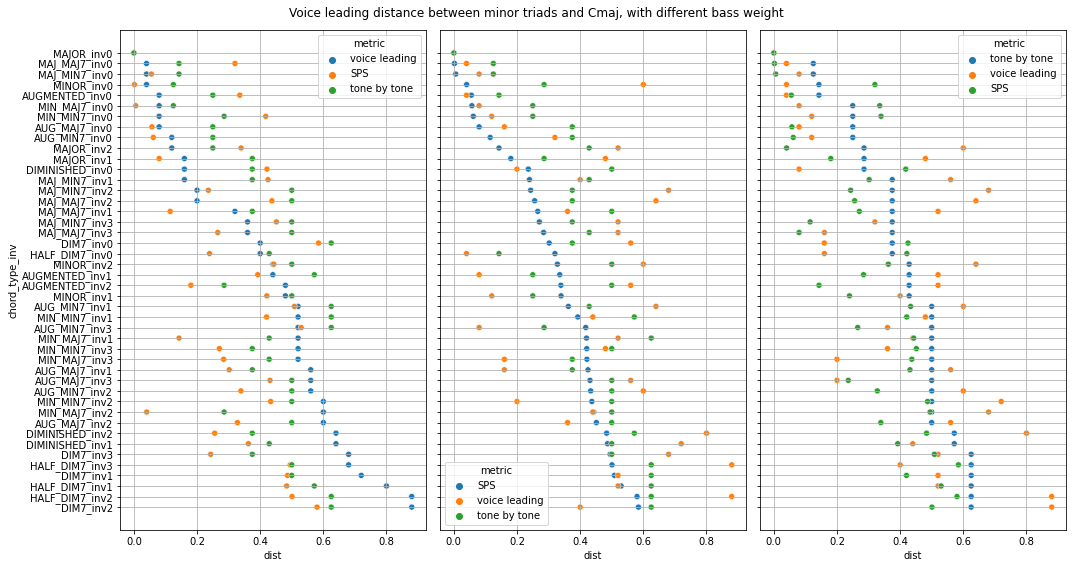

In [17]:
# Visualization of the output differences when changing the metric parameters :
# bass weight

fig, axs = plt.subplots(1,3,figsize = (15,8), sharey=True)

sns.scatterplot(data=sorted_by_vl.query('midi_root==0'), y="chord_type_inv", x="dist", hue="metric", ax=axs[0])

sns.scatterplot(data=sorted_by_sps.query('midi_root==0'), y="chord_type_inv", x="dist", hue="metric", ax=axs[1])

sns.scatterplot(data=sorted_by_tbt.query('midi_root==0'), y="chord_type_inv", x="dist", hue="metric", ax=axs[2])

for i in range(3):
    axs[i].grid()

fig.suptitle('Voice leading distance between minor triads and Cmaj, with different bass weight');
fig.tight_layout()

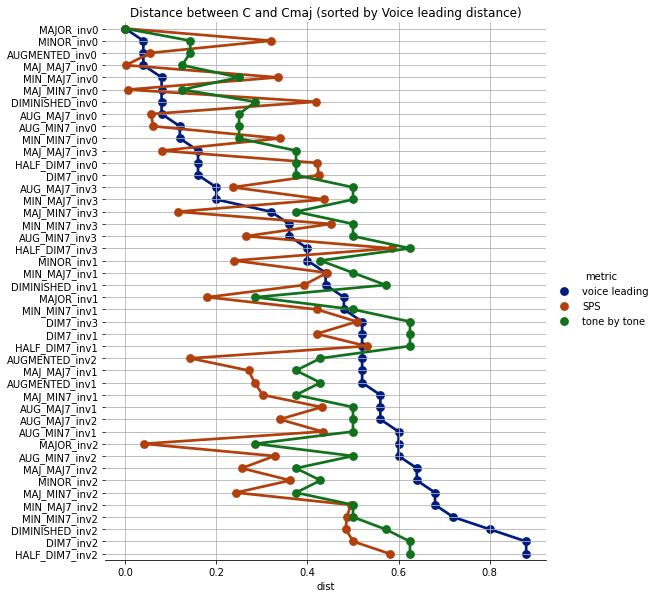

In [18]:
# Visualization of the results of the different metrics : every C chord with is comared against C major triad for each metric

g = sns.catplot(
    data=sorted_by_vl.query('midi_root==0'), kind="point",
    y="chord_type_inv", x="dist", hue="metric", palette="dark", height=8
)
g.despine(left=True)
g.set_axis_labels("dist", "")
g.set(title = 'Distance between C and Cmaj (sorted by Voice leading distance)')


fig.tight_layout()
plt.grid()

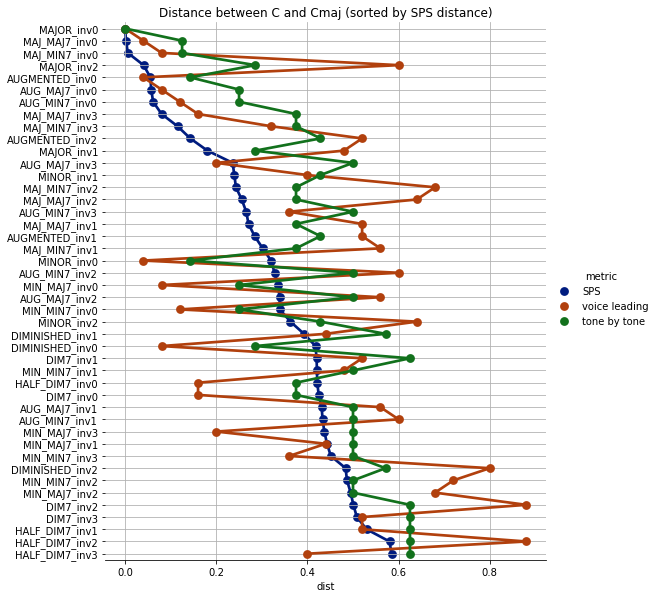

In [19]:
# Visualization of the results of the different metrics : every C chord with is comared against C major triad for each metric

g = sns.catplot(
    data=sorted_by_sps.query('midi_root==0'), kind="point",
    y="chord_type_inv", x="dist", hue="metric", palette="dark", height=8
)
g.despine(left=True)
g.set_axis_labels("dist", "")
g.set(title = 'Distance between C and Cmaj (sorted by SPS distance)')


fig.tight_layout()
plt.grid()

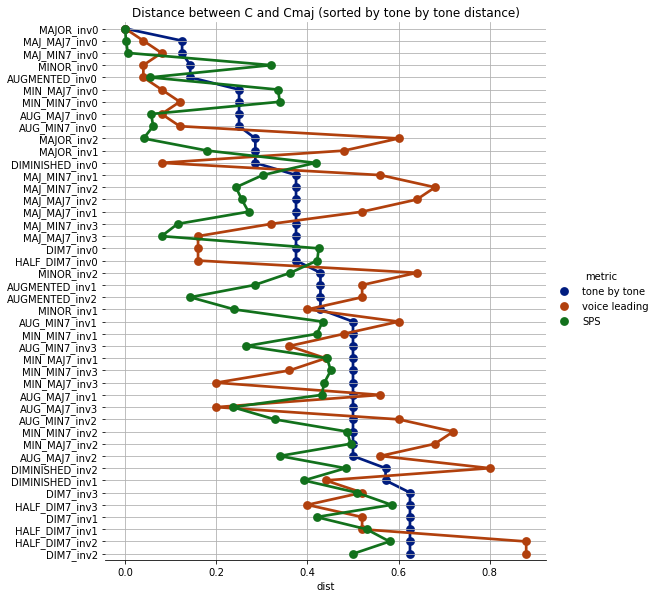

In [20]:
# Visualization of the results of the different metrics : every C chord with is comared against C major triad for each metric

g = sns.catplot(
    data=sorted_by_tbt.query('midi_root==0'), kind="point",
    y="chord_type_inv", x="dist", hue="metric", palette="dark", height=8
)
g.despine(left=True)
g.set_axis_labels("dist", "")
g.set(title = 'Distance between C and Cmaj (sorted by tone by tone distance)')

fig.tight_layout()
plt.grid()

___
___

# Corpus analysis

Here a corpus analysis is conducted. The harmonie of several pieces of a corpus has been evalated by a model so that each pieces has a set of ground truth chords and a set of estimated chords. Each pair of chords are here compared using the different metrics.

### Visualization of the average accuracy using the different metrics for each pieces


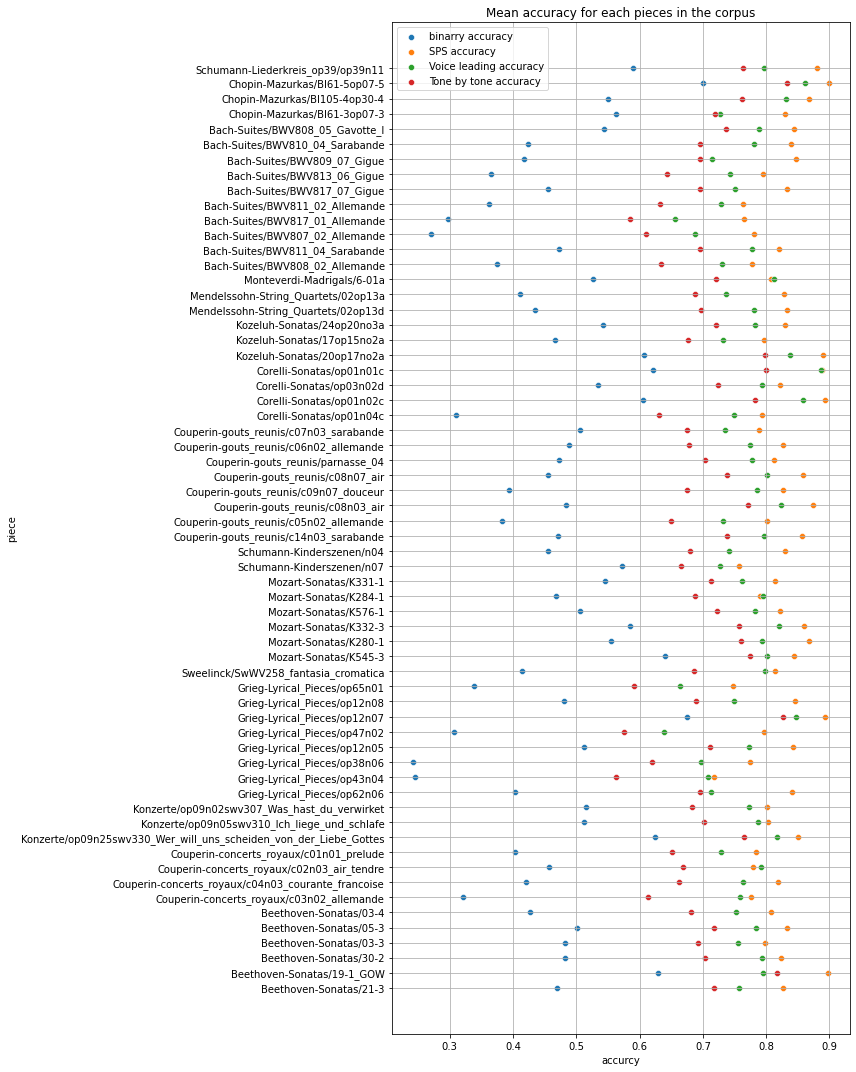

In [21]:
# Visualization of the average accuracy using the different metrics for each pieces

fig, ax = plt.subplots(1,1, figsize=(12,15))

sns.scatterplot(data=corpus_df, x='binary_accuracy', y='name', label='binarry accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='sps_accuracy', y='name', label='SPS accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='vl_accuracy', y='name', label='Voice leading accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='tbt_accuracy', y='name', label='Tone by tone accuracy', marker='o', ax=ax)
ax.set(title='Mean accuracy for each pieces in the corpus', xlabel='accurcy', ylabel='piece')
ax.grid()
ax.legend()
fig.tight_layout()

### Visualization of the average metric accuracy against each other 


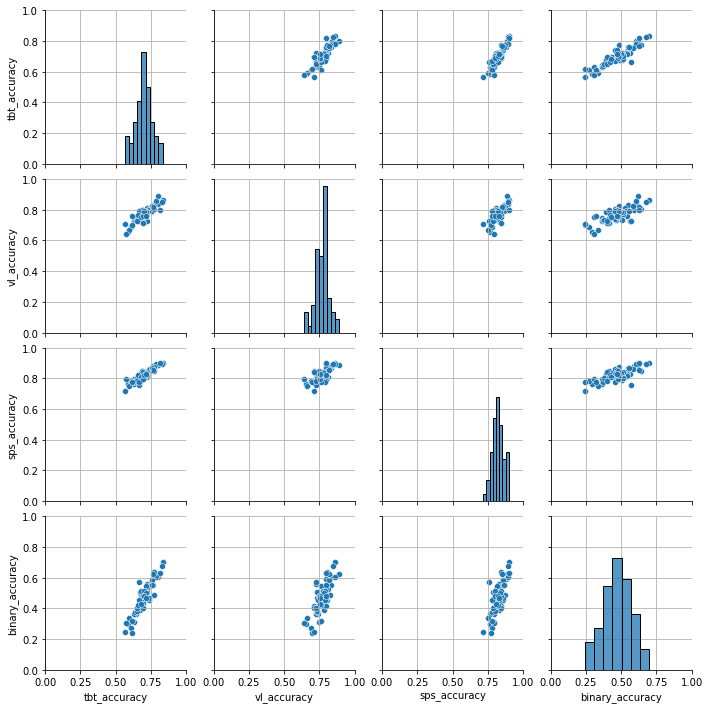

In [22]:
# Visualization of the average metric accuracy against each other 

g = sns.PairGrid(corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.set(ylim=(0,1), xlim=(0,1))
for i in range(4):
    for j in range(4):
        g.axes[i,j].grid()

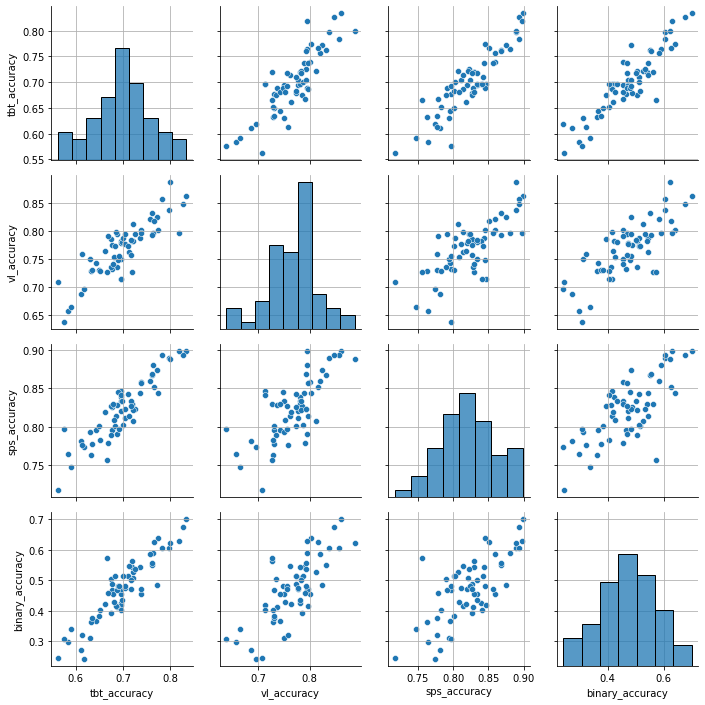

In [23]:
# Visualization of the average metric accuracy against each other 

g = sns.PairGrid(corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
for i in range(4):
    for j in range(4):
        g.axes[i,j].grid()

### Correclation between each average metric accuracy


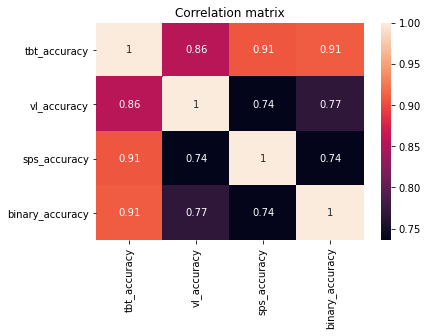

In [24]:
# Visualization of the correclation between each average metric accuracy

corr_matrix = corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']].corr()

ax = sns.heatmap(corr_matrix, annot=True)
ax.set(title='Correlation matrix', xlabel='', ylabel='')

fig.tight_layout()

___

## Linear regressions

Here one looks at the linear relationship that could stands out between the different metrics results.

In [25]:
accuracies = pd.DataFrame({'name':[name for name in corpus_df.name]*3})
accuracies['metric_accuracy'] = pd.concat([pd.concat([corpus_df['sps_accuracy'],corpus_df['vl_accuracy']],ignore_index=True),
                                            corpus_df['tbt_accuracy']],ignore_index=True)
accuracies['binary_accuracy'] = [accuracy for accuracy in corpus_df.binary_accuracy]*3
accuracies['metric'] = pd.Series(['SPS']*len(corpus_df) +['voice leading']*len(corpus_df)+['tone by tone']*len(corpus_df))

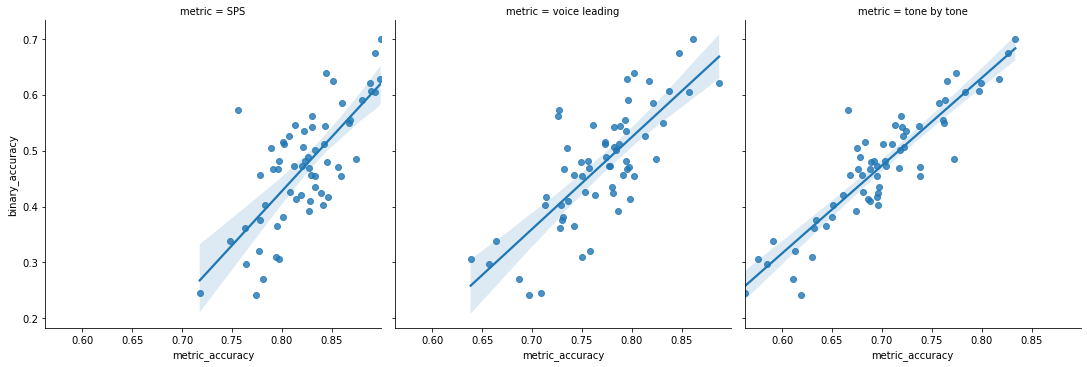

In [26]:
g = sns.lmplot(data=accuracies, x='metric_accuracy', y='binary_accuracy', col='metric')
#ax.set(title='Voice leading accuracy vs. tone by tone',xlabel='Tone by tone accurcy', ylabel='Voice leading accurcy')


In [27]:
mod = smf.ols(formula='binary_accuracy ~ sps_accuracy',
              data=corpus_df)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        binary_accuracy   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     71.85
Date:                Fri, 02 Jul 2021   Prob (F-statistic):           7.57e-12
Time:                        13:19:43   Log-Likelihood:                 77.115
No. Observations:                  62   AIC:                            -150.2
Df Residuals:                      60   BIC:                            -146.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1256      0.189     -5.965   

___
___

# Study of an outlier

Here we go into the details of why a particular piece stands out as an outlier.

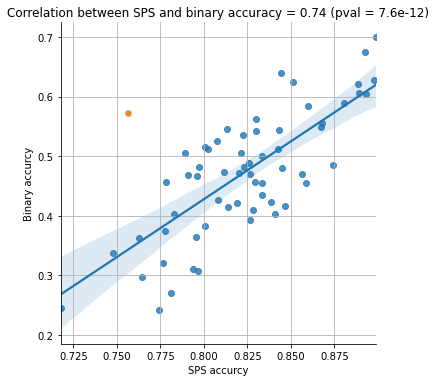

In [30]:
outlier_sps = corpus_df.sps_accuracy.nsmallest(3).iloc[2]
outlier = corpus_df.query('sps_accuracy == @outlier_sps').name.iloc[0]
corr_sps_b = stats.pearsonr(corpus_df['sps_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='sps_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('sps_accuracy == @outlier_sps'), x='sps_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between SPS and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

In [31]:
outlier

'Schumann-Kinderszenen/n07'

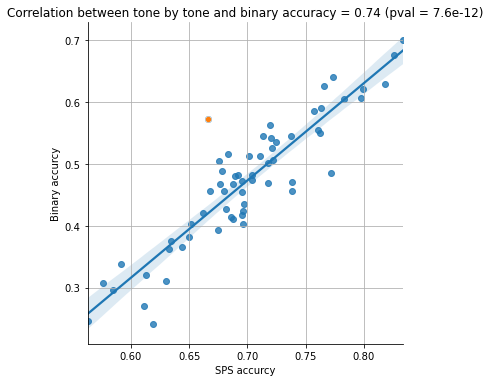

In [32]:
corr_tbt_b = stats.pearsonr(corpus_df['tbt_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='tbt_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('name == @outlier'), x='tbt_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between tone by tone and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

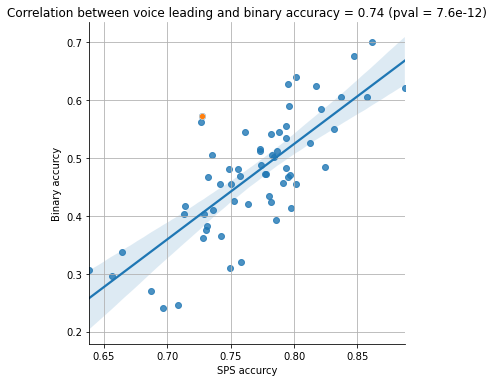

In [33]:
corr_vl_b = stats.pearsonr(corpus_df['vl_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='vl_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('name == @outlier'), x='vl_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between voice leading and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

In [34]:
path_outlier = '../Data/output_sps_kse-100/' + outlier + '_results.tsv'

SKn7_df = pd.read_csv(path_outlier,
                      sep='\t', index_col=0, converters={'duration': Fraction})

SKn7_df['gt_chord_type'] = SKn7_df['gt_chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
SKn7_df['est_chord_type'] = SKn7_df['est_chord_type'].apply(lambda r : ChordType[r.split(".")[1]])    

# SPS metric
SKn7_df['sps_distance'] = SKn7_df.apply(lambda r : get_distance(distance='SPS',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv
                                                                ), axis=1)

SKn7_df['sps_accuracy'] = SKn7_df['sps_distance'].apply(lambda sps :1-sps)

# Voice leading metric
SKn7_df['vl_distance'] = SKn7_df.apply(lambda r : get_distance(distance='voice leading',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv,
                                                               bass_weight=3
                                                                ), axis=1)

SKn7_df['vl_distance'] = SKn7_df['vl_distance'].apply(lambda r : r/max(SKn7_df['vl_distance']))
SKn7_df['vl_accuracy'] = SKn7_df['vl_distance'].apply(lambda vl :1-vl)

# Tone by tone metric
SKn7_df['tbt_distance'] = SKn7_df.apply(lambda r : get_distance(distance='tone by tone',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv,
                                                                bass_weight=3,
                                                                root_weight=3
                                                                ), axis=1)

SKn7_df['tbt_accuracy'] = SKn7_df['tbt_distance'].apply(lambda tbt :1-tbt)

In [35]:
false_est_df = SKn7_df.query('full_correct == False')

durations = false_est_df.groupby(['gt_chord', 'est_chord']).duration.sum().unstack().astype(float, copy=False)

# SPS metric
SPS_false_est_df = false_est_df[['gt_chord', 'est_chord','sps_accuracy']].drop_duplicates()
SPS_false_est_df = SPS_false_est_df.pivot(index='gt_chord', columns='est_chord', values='sps_accuracy')

# Voice leading metric
vl_false_est_df = false_est_df[['gt_chord', 'est_chord','vl_accuracy']].drop_duplicates()
vl_false_est_df = vl_false_est_df.pivot(index='gt_chord', columns='est_chord', values='vl_accuracy')

# Tone by tone metric
tbt_false_est_df = false_est_df[['gt_chord', 'est_chord','tbt_accuracy']].drop_duplicates()
tbt_false_est_df = tbt_false_est_df.pivot(index='gt_chord', columns='est_chord', values='tbt_accuracy')

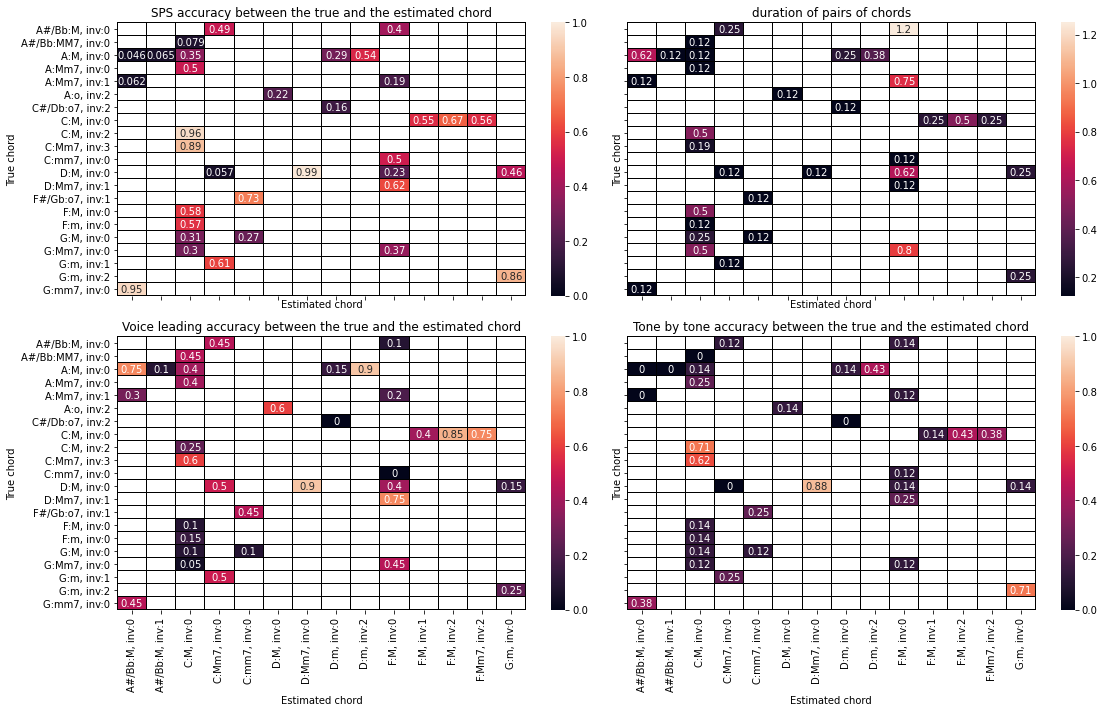

In [36]:
fig, axs = plt.subplots(2,2,figsize = (16,10), sharey=True, sharex=True)

sns.heatmap(SPS_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[0,0],
            linecolor = 'black', linewidths = 0.005)
axs[0,0].set(title='SPS accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(durations, annot = True, ax = axs[0,1], linecolor='black', linewidths = 0.005)
axs[0,1].set(title='duration of pairs of chords', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(vl_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[1,0],
            linecolor = 'black', linewidths = 0.005)
axs[1,0].set(title='Voice leading accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(tbt_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[1,1],
            linecolor = 'black', linewidths = 0.005)
axs[1,1].set(title='Tone by tone accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

fig.tight_layout()

___
## Program calsification

In [37]:
programs_sps_vs_bin = programs_corpus_df.pivot(index='name', columns='program', values='sps_accuracy')
programs_sps_vs_bin = programs_sps_vs_bin.merge(corpus_df[['name','binary_accuracy', 'vl_accuracy','tbt_accuracy']][:len(programs_sps_vs_bin)],
                          left_index=True, right_on='name').set_index('name')

In [ ]:
# Visualization of the correclation between each average metric accuracy

fig, ax = plt.subplots(1,1,figsize = (10,10), sharey=True, sharex=True)

corr_matrix_programs = programs_sps_vs_bin.corr()

sns.heatmap(corr_matrix_programs, annot=True, ax=ax)
ax.set(title='Correlation matrix', xlabel='', ylabel='')

fig.tight_layout()

In [ ]:
g = sns.lmplot(data=programs_corpus_df, x='sps_accuracy', y='binary_accuracy', col='program', col_wrap=4)
#ax.set(title='Voice leading accuracy vs. tone by tone',xlabel='Tone by tone accurcy', ylabel='Voice leading accurcy')


___
### Forbid duplicates for Voice leading comparison

In [3]:
# df with difference of the output of the two vl distance

dupl_vl_diff = dist_to_Cmaj[['midi_root','chord_type_inv']]

dupl_vl_diff['vl_diff'] = dist_to_Cmaj.voice_leading_dist - dist_to_Cmaj.vl_dist_nodupl


<ipython-input-3-a0ee9498737f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupl_vl_diff['vl_diff'] = dist_to_Cmaj.voice_leading_dist - dist_to_Cmaj.vl_dist_nodupl


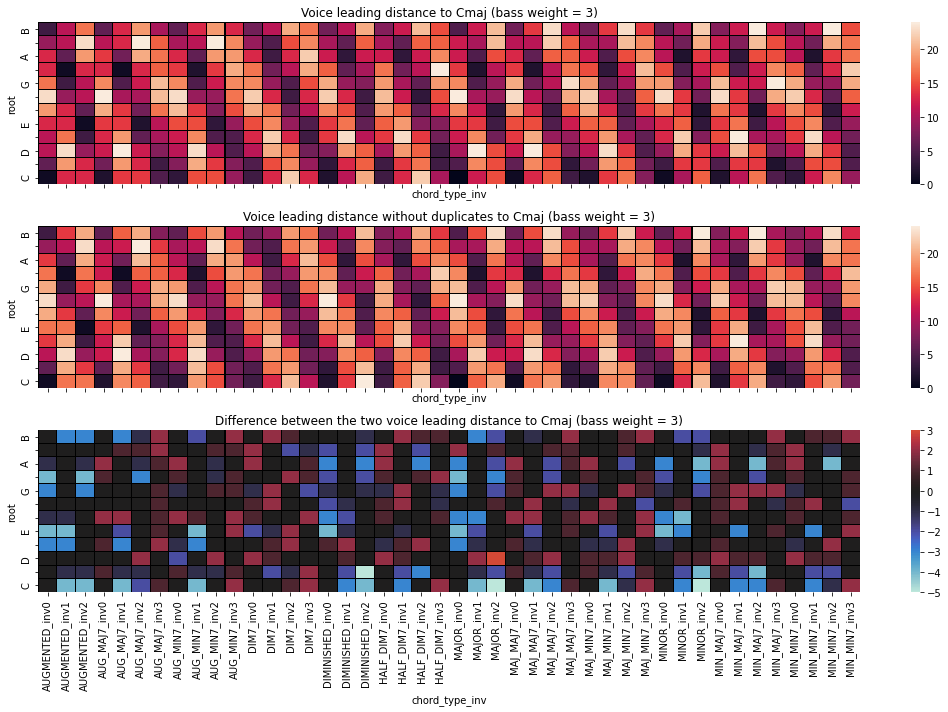

In [4]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric
fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)
    
to_plot_vl = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='voice_leading_dist').sort_values('midi_root', ascending=False)

to_plot_vl_nodupl = dist_to_Cmaj.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_dist_nodupl').sort_values('midi_root', ascending=False)

to_plot_vl_diff = dupl_vl_diff.pivot(index='midi_root', 
                                     columns='chord_type_inv', 
                                     values='vl_diff').sort_values('midi_root', ascending=False)
    
yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_vl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'Voice leading distance to Cmaj (bass weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl_nodupl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Voice leading distance without duplicates to Cmaj (bass weight = 3)', ylabel='root')

sns.heatmap(to_plot_vl_diff, yticklabels=yticklabels, center=0,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Difference between the two voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()

___
### Tonal pitch class in voice leading distance

In [5]:
# df with difference of the output of the two vl distance

tpc_vl_diff = dist_to_Cmaj[['midi_root','chord_type_inv']]

tpc_vl_diff['vl_diff'] = dist_to_Cmaj.voice_leading_dist - dist_to_Cmaj.vl_dist_tpc


<ipython-input-5-1fc8d7f2e64c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tpc_vl_diff['vl_diff'] = dist_to_Cmaj.voice_leading_dist - dist_to_Cmaj.vl_dist_tpc


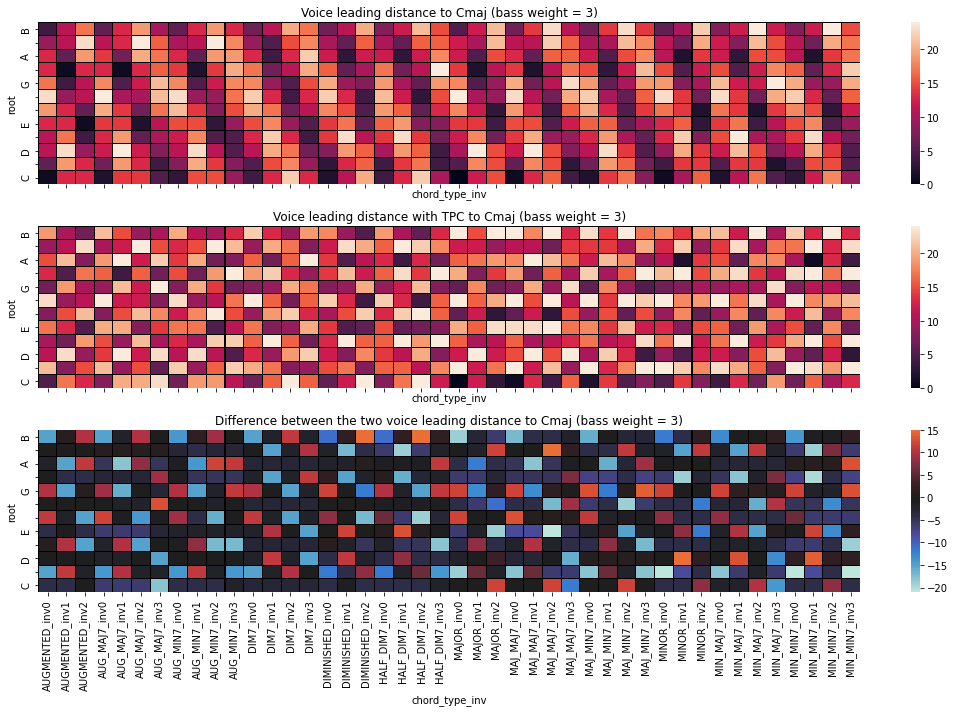

In [6]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric

fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)
    
to_plot_vl = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='voice_leading_dist').sort_values('midi_root', ascending=False)

to_plot_vl_tpc = dist_to_Cmaj.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_dist_tpc').sort_values('midi_root', ascending=False)

to_plot_vl_diff = tpc_vl_diff.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_diff').sort_values('midi_root', ascending=False)
    
yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_vl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'Voice leading distance to Cmaj (bass weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl_tpc, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Voice leading distance with TPC to Cmaj (bass weight = 3)', ylabel='root')

sns.heatmap(to_plot_vl_diff, yticklabels=yticklabels, center=0,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Difference between the two voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()

___
### Tonal pitch class without duplicates in voice leading distance

In [ ]:
# df with difference of the output of the two vl distance

tpc_dupl_vl_diff = dist_to_Cmaj[['midi_root','chord_type_inv']]

tpc_dupl_vl_diff['vl_diff'] = dist_to_Cmaj.vl_dist_tpc - dist_to_Cmaj.vl_dist_tpc_nodupl


In [ ]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric

fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)
    
to_plot_vl_tpc = dist_to_Cmaj.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_dist_tpc').sort_values('midi_root', ascending=False)

to_plot_vl_tpc_nodupl = dist_to_Cmaj.pivot(index='midi_root', 
                                        columns='chord_type_inv', 
                                        values='vl_dist_tpc_nodupl').sort_values('midi_root', ascending=False)

to_plot_vl_diff = tpc_dupl_vl_diff.pivot(index='midi_root', 
                                         columns='chord_type_inv', 
                                         values='vl_diff').sort_values('midi_root', ascending=False)
    
yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_vl_tpc, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'Voice leading distance with TPC to Cmaj (bass weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl_tpc_nodupl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Voice leading distance with TPC without duplicates to Cmaj (bass weight = 3)', ylabel='root')

sns.heatmap(to_plot_vl_diff, yticklabels=yticklabels, center=0,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Difference between the two voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()

___
### Tonal pitch class for only the bass in voice leading distance

In [ ]:
# df with difference of the output of the two vl distance

tpc_bass_vl_diff = dist_to_Cmaj[['midi_root','chord_type_inv']]

tpc_bass_vl_diff['vl_diff'] = dist_to_Cmaj.voice_leading_dist - dist_to_Cmaj.vl_dist_tpc_bass


In [ ]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric
fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)
    
to_plot_vl = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='voice_leading_dist').sort_values('midi_root', ascending=False)

to_plot_vl_tpc_bass = dist_to_Cmaj.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_dist_tpc_bass').sort_values('midi_root', ascending=False)

to_plot_vl_diff = tpc_bass_vl_diff.pivot(index='midi_root', 
                                     columns='chord_type_inv', 
                                     values='vl_diff').sort_values('midi_root', ascending=False)
    
yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_vl, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'Voice leading distance to Cmaj (bass weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl_tpc_bass, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Voice leading distance, TPC bass (bass weight = 3)', ylabel='root')

sns.heatmap(to_plot_vl_diff, yticklabels=yticklabels, center=0,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Difference between the two voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()

In [ ]:
# df with difference of the output of the two vl distance

tpc_bass_vl_diff = dist_to_Cmaj[['midi_root','chord_type_inv']]

tpc_bass_vl_diff['vl_diff'] = dist_to_Cmaj.vl_dist_tpc - dist_to_Cmaj.vl_dist_tpc_bass

In [ ]:
# Visualization of the results of the different metrics : every chord with is comared against C major triad for each metric
fig, axs = plt.subplots(3,1,figsize = (15,10), sharex=True)
    
to_plot_vl_tpc = dist_to_Cmaj.pivot(index='midi_root', 
                                columns='chord_type_inv', 
                                values='vl_dist_tpc').sort_values('midi_root', ascending=False)

to_plot_vl_tpc_bass = dist_to_Cmaj.pivot(index='midi_root', 
                                    columns='chord_type_inv', 
                                    values='vl_dist_tpc_bass').sort_values('midi_root', ascending=False)

to_plot_vl_diff = tpc_bass_vl_diff.pivot(index='midi_root', 
                                     columns='chord_type_inv', 
                                     values='vl_diff').sort_values('midi_root', ascending=False)
    
yticklabels = ['B','','A','','G','','','E','','D','','C']

sns.heatmap(to_plot_vl_tpc, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[0])
axs[0].set(title = 'Voice leading distance to Cmaj (bass weight = 3)', ylabel='root')    

sns.heatmap(to_plot_vl_tpc_bass, yticklabels=yticklabels,
            vmin=0, vmax=24, #center=0.5,
            linecolor = 'black', linewidths = 0.005, ax=axs[1])
axs[1].set(title = 'Voice leading distance, TPC bass (bass weight = 3)', ylabel='root')

sns.heatmap(to_plot_vl_diff, yticklabels=yticklabels, center=0,
            linecolor = 'black', linewidths = 0.005, ax=axs[2])
axs[2].set(title = 'Difference between the two voice leading distance to Cmaj (bass weight = 3)', ylabel='root')

fig.tight_layout()